**Outline of Steps**
    + Initialization
        + Download VOC data from http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
        + Download pre-trained weights from http://pjreddie.com/media/files/tiny-yolo-voc.weights
        + Specify the directory of annotations by setting variable *ann_di*
        + Specify the directory of images by setting variable *img_dir*
        + Specity the path of pre-trained weights by setting variable *wt_path*
    + Construct equivalent network in Keras
        + Network arch from https://github.com/pjreddie/darknet/blob/master/cfg/tiny-yolo-voc.cfg
    + Load the pretrained weights
    + Preprocess VOC data
    + Perform training (for POC, the weights of the last layers are randomized before training)
    + Perform detection on an image with newly trained weights

## Initialization

In [1]:
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import random
import os

%matplotlib inline

Using TensorFlow backend.


In [7]:
orig_weight_path = 'orig_weights.hdf5'    
ann_dir = 'data/ILSVRC/Annotations/DET/train/ILSVRC2014_train_0000/'
img_dir = 'data/ILSVRC/Data/DET/train/ILSVRC2014_train_0000/'

In [3]:
exec(open("./utils.py").read())

NORM_H, NORM_W = 416, 416
GRID_H, GRID_W = 13 , 13
BATCH_SIZE = 8
BOX = 5
ORIG_CLASS = 20

LABEL_FILE = 'data/ILSVRC/synset_words_2.txt'

THRESHOLD = 0.2
ANCHORS = '1.08,1.19,  3.42,4.41,  6.63,11.38,  9.42,5.11,  16.62,10.52'
ANCHORS = [float(ANCHORS.strip()) for ANCHORS in ANCHORS.split(',')]
SCALE_NOOB, SCALE_CONF, SCALE_COOR, SCALE_PROB = 0.5, 5.0, 5.0, 1.0
weight_reader = WeightReader(wt_path)

## Load network

In [5]:
model = Sequential()

# Layer 1
model.add(Conv2D(16, (3,3), strides=(1,1), padding='same', use_bias=False, input_shape=(416,416,3)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2 - 5
for i in range(0,4):
    model.add(Conv2D(32*(2**i), (3,3), strides=(1,1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 6
model.add(Conv2D(512, (3,3), strides=(1,1), padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='same'))

# Layer 7 - 8
for _ in range(0,2):
    model.add(Conv2D(1024, (3,3), strides=(1,1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))

# Layer 9
model.add(Conv2D(BOX * (4 + 1 + ORIG_CLASS), (1, 1), strides=(1, 1), kernel_initializer='he_normal'))
model.add(Activation('linear'))
model.add(Reshape((GRID_H, GRID_W, BOX, 4 + 1 + ORIG_CLASS)))

In [8]:
model.load_weights(orig_weight_path)

## Preprocess VOC data

In [9]:
anns, labels = parse_annotation(ann_dir)

Number of classes present in this ImageNet set: 184


In [10]:
CLASS = 184

In [14]:
idx = random.randint(0, 9999)
print(idx)
anns[idx]

2925


{'filename': 'ILSVRC2014_train_00005371',
 'height': 375,
 'object': [{'name': 'n02437136',
   'xmax': 381,
   'xmin': 26,
   'ymax': 321,
   'ymin': 23},
  {'name': 'n02437136', 'xmax': 499, 'xmin': 257, 'ymax': 218, 'ymin': 82},
  {'name': 'n00007846', 'xmax': 138, 'xmin': 67, 'ymax': 374, 'ymin': 167}],
 'width': 500}

## Perform training

**Loss function**

$$\begin{multline}
\lambda_\textbf{coord}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
     L_{ij}^{\text{obj}}
            \left[
            \left(
                x_i - \hat{x}_i
            \right)^2 +
            \left(
                y_i - \hat{y}_i
            \right)^2
            \right]
\\
+ \lambda_\textbf{coord} 
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
         L_{ij}^{\text{obj}}
         \left[
        \left(
            \sqrt{w_i} - \sqrt{\hat{w}_i}
        \right)^2 +
        \left(
            \sqrt{h_i} - \sqrt{\hat{h}_i}
        \right)^2
        \right]
\\
+ \sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
        L_{ij}^{\text{obj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \lambda_\textrm{noobj}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
    L_{ij}^{\text{noobj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \sum_{i = 0}^{S^2}
L_i^{\text{obj}}
    \sum_{c \in \textrm{classes}}
        \left(
            p_i(c) - \hat{p}_i(c)
        \right)^2
\end{multline}$$

In [16]:
def custom_loss(y_true, y_pred):
    ### Adjust prediction
    # adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[:,:,:,:,:2])
    
    # adjust w and h
    pred_box_wh = tf.exp(y_pred[:,:,:,:,2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    pred_box_wh = tf.sqrt(pred_box_wh / np.reshape([float(GRID_W), float(GRID_H)], [1,1,1,1,2]))
    
    # adjust confidence
    pred_box_conf = tf.expand_dims(tf.sigmoid(y_pred[:, :, :, :, 4]), -1)
    
    # adjust probability
    pred_box_prob = tf.nn.softmax(y_pred[:, :, :, :, 5:])
    
    y_pred = tf.concat([pred_box_xy, pred_box_wh, pred_box_conf, pred_box_prob], 4)
    print("Y_pred shape: {}".format(y_pred.shape))
    
    ### Adjust ground truth
    # adjust x and y
    center_xy = .5*(y_true[:,:,:,:,0:2] + y_true[:,:,:,:,2:4])
    center_xy = center_xy / np.reshape([(float(NORM_W)/GRID_W), (float(NORM_H)/GRID_H)], [1,1,1,1,2])
    true_box_xy = center_xy - tf.floor(center_xy)
    
    # adjust w and h
    true_box_wh = (y_true[:,:,:,:,2:4] - y_true[:,:,:,:,0:2])
    true_box_wh = tf.sqrt(true_box_wh / np.reshape([float(NORM_W), float(NORM_H)], [1,1,1,1,2]))
    
    # adjust confidence
    pred_tem_wh = tf.pow(pred_box_wh, 2) * np.reshape([GRID_W, GRID_H], [1,1,1,1,2])
    pred_box_area = pred_tem_wh[:,:,:,:,0] * pred_tem_wh[:,:,:,:,1]
    pred_box_ul = pred_box_xy - 0.5 * pred_tem_wh
    pred_box_bd = pred_box_xy + 0.5 * pred_tem_wh
    
    true_tem_wh = tf.pow(true_box_wh, 2) * np.reshape([GRID_W, GRID_H], [1,1,1,1,2])
    true_box_area = true_tem_wh[:,:,:,:,0] * true_tem_wh[:,:,:,:,1]
    true_box_ul = true_box_xy - 0.5 * true_tem_wh
    true_box_bd = true_box_xy + 0.5 * true_tem_wh
    
    intersect_ul = tf.maximum(pred_box_ul, true_box_ul) 
    intersect_br = tf.minimum(pred_box_bd, true_box_bd)
    intersect_wh = intersect_br - intersect_ul
    intersect_wh = tf.maximum(intersect_wh, 0.0)
    intersect_area = intersect_wh[:,:,:,:,0] * intersect_wh[:,:,:,:,1]
    
    iou = tf.truediv(intersect_area, true_box_area + pred_box_area - intersect_area)
    best_box = tf.equal(iou, tf.reduce_max(iou, [3], True)) 
    best_box = tf.to_float(best_box)
    true_box_conf = tf.expand_dims(best_box * y_true[:,:,:,:,4], -1)
    
    # adjust confidence
    true_box_prob = y_true[:,:,:,:,5:]
    
    y_true = tf.concat([true_box_xy, true_box_wh, true_box_conf, true_box_prob], 4)
    print("Y_true shape: {}".format(y_true.shape))
    #y_true = tf.Print(y_true, [true_box_wh], message='DEBUG', summarize=30000)    
    
    ### Compute the weights
    weight_coor = tf.concat(4 * [true_box_conf], 4)
    weight_coor = SCALE_COOR * weight_coor
    
    weight_conf = SCALE_NOOB * (1. - true_box_conf) + SCALE_CONF * true_box_conf
    
    weight_prob = tf.concat(CLASS * [true_box_conf], 4) 
    weight_prob = SCALE_PROB * weight_prob 
    
    weight = tf.concat([weight_coor, weight_conf, weight_prob], 4)
    print("Weight shape: {}".format(weight.shape))
    
    ### Finalize the loss
    loss = tf.pow(y_pred - y_true, 2)
    loss = loss * weight
    loss = tf.reshape(loss, [-1, GRID_W*GRID_H*BOX*(4 + 1 + CLASS)])
    loss = tf.reduce_sum(loss, 1)
    loss = .5 * tf.reduce_mean(loss)
    
    return loss

## Fine-tuning

In [17]:
# freeze first 8 layers
for layer in model.layers:
    layer.trainable = False

**Add new, randomized final 3 layers with new class size**

In [18]:
connecting_layer = model.layers[-4].output

In [19]:
top_model = Conv2D(BOX * (4 + 1 + CLASS), (1, 1), strides=(1, 1), kernel_initializer='he_normal') (connecting_layer)
top_model = Activation('linear') (top_model)
top_model = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS)) (top_model)

In [20]:
new_model = Model(model.input, top_model)

In [31]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18_input (InputLayer) (None, 416, 416, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 416, 416, 16)      432       
_________________________________________________________________
batch_normalization_17 (Batc (None, 416, 416, 16)      64        
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 416, 416, 16)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 208, 208, 16)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 208, 208, 32)      4608      
_________________________________________________________________
batch_normalization_18 (Batc (None, 208, 208, 32)      128       
__________

**Retrain the network**

In [21]:
early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=3, mode='min', verbose=1)
checkpoint = ModelCheckpoint('weights.hdf5', monitor='loss', verbose=1, save_best_only=True, mode='min', period=1)

In [24]:
sgd = SGD(lr=0.00001, decay=0.0005, momentum=0.9)
#adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

new_model.compile(loss=custom_loss, optimizer=sgd)
new_model.fit_generator(data_gen(anns, BATCH_SIZE), 
                    int(len(anns)/BATCH_SIZE), 
                    epochs = 100, 
                    verbose = 2,
                    callbacks = [early_stop, checkpoint],
                    max_q_size = 3)

Y_pred shape: (?, 13, 13, 5, 189)
Y_true shape: (?, 13, 13, 5, ?)
Weight shape: (?, 13, 13, 5, 189)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 1249, epochs=100, max_queue_size=3, callbacks=[<keras.ca..., verbose=2)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/100
Epoch 00000: loss improved from inf to 8.95365, saving model to weights.hdf5
165s - loss: 8.9537
Epoch 2/100
Epoch 00001: loss improved from 8.95365 to 7.95725, saving model to weights.hdf5
146s - loss: 7.9573
Epoch 3/100
Epoch 00002: loss improved from 7.95725 to 7.94697, saving model to weights.hdf5
80s - loss: 7.9019
Epoch 4/100
Epoch 00003: loss improved from 7.94697 to 7.74858, saving model to weights.hdf5
70s - loss: 7.7486
Epoch 5/100
Epoch 00004: loss did not improve
70s - loss: 8.0012
Epoch 6/100
Epoch 00005: loss did not improve
71s - loss: 7.8616
Epoch 7/100
Epoch 00006: loss improved from 7.74858 to 7.69704, saving model to weights.hdf5
70s - loss: 7.6970
Epoch 8/100
Epoch 00007: loss did not improve
72s - loss: 7.7111
Epoch 9/100
Epoch 00008: loss did not improve
68s - loss: 7.7542
Epoch 10/100
Epoch 00009: loss did not improve
67s - loss: 7.7466
Epoch 11/100
Epoch 00010: loss did not improve
67s - loss: 7.8652
Epoch 00010: early stopping


## Perform detection on image

In [32]:
new_model.load_weights("weights.hdf5")

In [63]:
exec(open("./utils.py").read())

Number of initial boxes: 845
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest b

Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
Highest box probability for box: 0.0
H

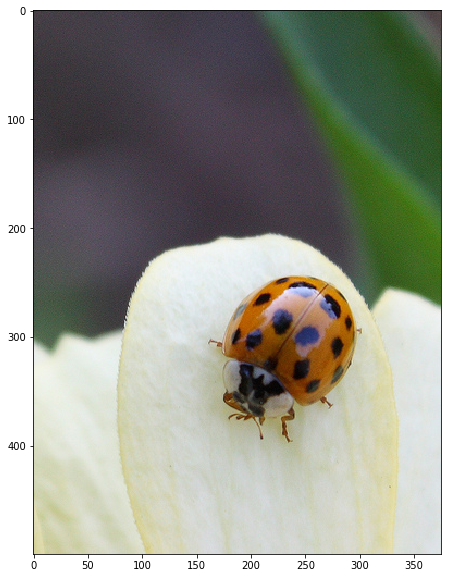

In [25]:
image = cv2.imread('imagenet_samples/ILSVRC2014_train_00000124.JPEG')

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (416, 416))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = new_model.predict(input_image)

#print netout
image = interpret_netout(image, netout[0])
plt.imshow(image[:,:,::-1]); plt.show()